# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

import warnings
warnings.filterwarnings('ignore')

from src.metrics import precision, recall, map_at_k
from src.utils import prefilter_items, reduce_mem_usage
from src.recommenders import MainRecommender

# Read data

In [2]:
data = reduce_mem_usage(pd.read_csv('data/retail_train.csv'))
item_features = reduce_mem_usage(pd.read_csv('data/product.csv'))
user_features = reduce_mem_usage(pd.read_csv('data/hh_demographic.csv'))
test_data = reduce_mem_usage(pd.read_csv('data/retail_test1.csv'))
data_train = data.copy()

Memory usage of dataframe is 219.43 MB
Memory usage after optimization is: 98.29 MB
Decreased by 55.2%
Memory usage of dataframe is 4.93 MB
Memory usage after optimization is: 1.53 MB
Decreased by 68.9%
Memory usage of dataframe is 0.05 MB
Memory usage after optimization is: 0.01 MB
Decreased by 82.8%
Memory usage of dataframe is 8.12 MB
Memory usage after optimization is: 3.64 MB
Decreased by 55.2%


In [3]:
# уникальные юзеры в test
test_data[~test_data['user_id'].isin(data['user_id'])]['user_id'].unique()

array([2325], dtype=int16)

In [4]:
# холодный старт не рассматривается поэтому юзера удаляем из test выборки.
# альтернатива - предложить товары из топа
test_data.drop(test_data[test_data['user_id'] == 2325].index,  
              inplace=True)

## Preprocessing, data split

In [5]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [6]:
N_TOP_ITEMS = 10000 # выбор топ товаров

In [7]:
VAL_MATCHER_WEEKS = 6

In [8]:
# данные для валидации matching модели
data_val_matcher = data_train[data_train['week_no'] >= data_train['week_no'].max() - VAL_MATCHER_WEEKS]

In [9]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train,
                             group_col='item_id',
                             popular_col='quantity',
                             top_popular_filter_choose=N_TOP_ITEMS,
                             )

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Отфильтровано 522888 записей
Decreased # items from 89051 to 10001


In [10]:
# данные для тренировки matching модели
data_train_matcher = data_train[data_train['week_no'] < data_train['week_no'].max() - VAL_MATCHER_WEEKS]

# SEARCH PARAMS

In [11]:
result_eval_matcher_ = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher_.columns=[USER_COL, ACTUAL_COL]

In [ ]:
N_PREDICT = 200
score_dict = {}
for factors in range(120, 181, 10):
    for reg in (np.linspace(0.01, 0.2, 10)):
        result_eval_matcher = result_eval_matcher_.copy()
        recommender = MainRecommender(verbose=False,
                                      n_factors=factors,
                                      regularization=reg)
        recommender.fit(data_train_matcher)
        result_eval_matcher['candidates'] = result_eval_matcher[USER_COL].apply(
            lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

#         score = result_eval_matcher.apply(lambda row: recall(
#             row['candidates'], row['actual']), axis=1).mean()
        score = map_at_k(result_eval_matcher['candidates'],  result_eval_matcher['actual'], top_k=5)

        score_dict[f'fac{factors}_reg{round(reg,3)}'] = score


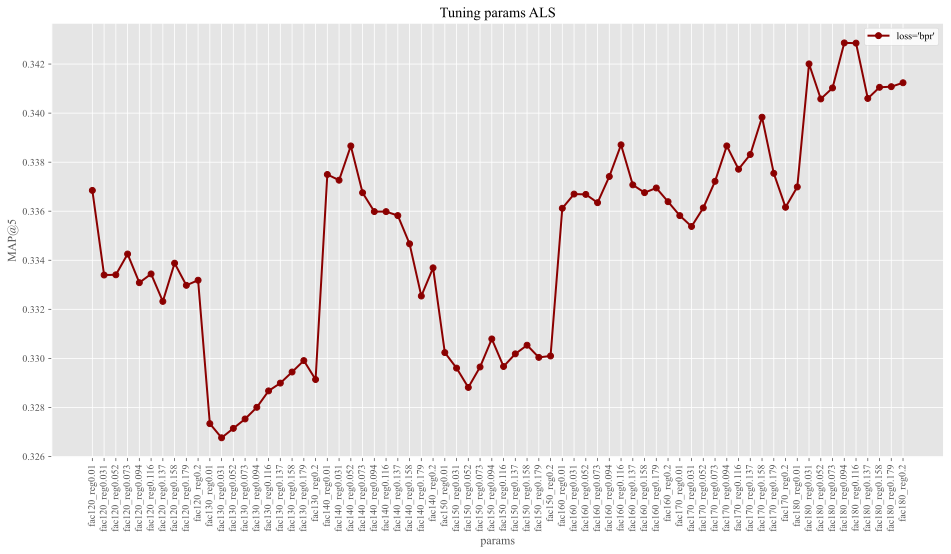

In [15]:
plt.figure(figsize=(16, 8))
plt.xlabel('params')
plt.ylabel('MAP@5')
plt.title('Tuning params ALS')
plt.plot(score_dict.keys(), score_dict.values(), color='darkred',
         marker='o',  linewidth=2, label="loss='bpr'",)
plt.xticks(rotation=90)
plt.legend(loc='best', facecolor='white')
plt.show()